<a href="https://colab.research.google.com/github/Erfanhajiesmaeili/FOMC_Sentiment_Analysis/blob/main/FOMC_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FOMC Sentiment Analysis for Inflation Prediction

**Author:** [Erfan Hajiesmaeili]
**Date:** 2025-10-12

---

## Part 1: Setup and Initialization
*In this section, we mount the Google Drive, install necessary libraries, and define the project's directory paths.*

---

## Part 2: Data Collection (Web Scraping)
*Here, we will write and execute the script to scrape FOMC statements from the Federal Reserve's website.*

---

## Part 3: Data Preparation and Merging
*In this part, we will fetch the economic data (our target variable) from FRED and merge it with the scraped text data.*

---
## Part 4: Sentiment Analysis and Feature Engineering
*This section will contain the core logic for extracting sentiment scores from the text using both traditional and deep learning methods.*

---
## Part 5: Time Series Modeling
*We will build, train, and test our time series forecasting models (both baseline and advanced DL models) here.*

---
## Part 6: Evaluation and Conclusion
*Finally, we will evaluate the model performance, visualize the results, and draw conclusions from our analysis.*

In [3]:
import pandas as pd
import os
import pandas_datareader.data as web
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import re
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [4]:
# Part 1

!pip install -q pandas requests beautifulsoup4 pandas-datareader statsmodels transformers torch

# The base path to our project folder in Google Drive
PROJECT_PATH = '/content/drive/My Drive/fomc-sentiment-analyzer'

# Specific paths for data and source code
DATA_PATH = os.path.join(PROJECT_PATH, 'data')
SRC_PATH = os.path.join(PROJECT_PATH, 'src')

# Verify that the paths exist, create them if they don't (just in case)
os.makedirs(DATA_PATH, exist_ok=True)
os.makedirs(SRC_PATH, exist_ok=True)

print("Setup Complete! Libraries are installed and project paths are defined.")
print(f"Data will be saved in: {DATA_PATH}")

Setup Complete! Libraries are installed and project paths are defined.
Data will be saved in: /content/drive/My Drive/fomc-sentiment-analyzer/data


Part 2: Data Collection (Web Scraping)

In [5]:
# Part 2: Data Collection


# --- Step 1: Install gdown for Google Drive access ---
!pip install -q gdown

# --- Step 2: Define your File ID and download the data ---
print("--- Accessing your custom dataset from Google Drive ---")

try:
    # The File ID from the link you provided
    YOUR_FILE_ID_HERE = "1MqINIWAF-DvaclAtb2mEYbzzT70iS8-Q"
    OUTPUT_CSV_PATH = os.path.join(DATA_PATH, 'fomc_statements.csv')

    # Download the file using gdown
    import gdown
    gdown.download(id=YOUR_FILE_ID_HERE, output=OUTPUT_CSV_PATH, quiet=False, fuzzy=True)

    # --- Step 3: Load and format the data ---
    df_custom = pd.read_csv(OUTPUT_CSV_PATH)

    print("\nColumns found in your file:", df_custom.columns.tolist())

    # --- THE FIX IS HERE: Using the correct column names from your file ---
    df_custom = df_custom.rename(columns={
        'Release Date': 'date',
        'Text': 'statement_text'
    })

    # Now that the columns are correctly named, the rest of the code will work.
    df_custom['date'] = pd.to_datetime(df_custom['date'])
    df_custom = df_custom[['date', 'statement_text']]
    df_custom = df_custom.sort_values(by='date', ascending=False).reset_index(drop=True)

    # Overwrite the file with the cleaned version
    df_custom.to_csv(OUTPUT_CSV_PATH, index=False, encoding='utf-8')

    print(f"\n✅ Success! Loaded and formatted {len(df_custom)} statements from your file.")
    print(f"Data ranges from {df_custom['date'].min().date()} to {df_custom['date'].max().date()}.")

except Exception as e:
    print(f"An error occurred. Details: {e}")

--- Accessing your custom dataset from Google Drive ---


Downloading...
From: https://drive.google.com/uc?id=1MqINIWAF-DvaclAtb2mEYbzzT70iS8-Q
To: /content/drive/My Drive/fomc-sentiment-analyzer/data/fomc_statements.csv
100%|██████████| 12.0M/12.0M [00:00<00:00, 31.9MB/s]



Columns found in your file: ['Date', 'Release Date', 'Type', 'Text']

✅ Success! Loaded and formatted 454 statements from your file.
Data ranges from 2000-02-02 to 2025-10-08.


Part 3: Data Preparation and Merging

In [6]:
# Part 3


print("--- Step 3.1: Loading Scraped FOMC Statements ---")
statements_csv_path = os.path.join(DATA_PATH, 'fomc_statements.csv')

# Load the data, ensuring the 'date' column is parsed correctly
try:
    df_statements = pd.read_csv(statements_csv_path, parse_dates=['date'])
    print(f"Successfully loaded {len(df_statements)} statements.")
    print("Sample of the loaded data:")
    print(df_statements.head())
    print("\n")
except FileNotFoundError:
    print(f"Error: The file was not found at {statements_csv_path}")
    print("Please make sure you have successfully run the scraper in Part 2.")

# Fetching Economic Data (Inflation Expectations)
print("--- Step 3.2: Fetching Economic Data from FRED ---")
# We will use the University of Michigan's Inflation Expectation series (Ticker: MICH)
fred_ticker = 'MICH'
start_date = datetime(1990, 1, 1)
end_date = datetime.now()

try:
    # Fetch data from FRED using pandas_datareader
    df_econ = web.DataReader(fred_ticker, 'fred', start_date, end_date)
    df_econ = df_econ.rename(columns={'MICH': 'inflation_expectation'})
    print(f"Successfully fetched {len(df_econ)} monthly data points for {fred_ticker}.")
    print("Sample of the economic data:")
    print(df_econ.head())
    print("\n")
except Exception as e:
    print(f"Error fetching data from FRED: {e}")


# Aligning and Merging DataFrames
print("--- Step 3.3: Aligning and Merging DataFrames ---")
# We will align the statement's date to the first day of its month to merge.

# Create a 'month_year' key for the statements DataFrame
df_statements['month_year'] = df_statements['date'].dt.to_period('M').dt.to_timestamp()

# The economic data's index is already the date, we reset it to become a column
df_econ_reset = df_econ.reset_index()
df_econ_reset = df_econ_reset.rename(columns={'DATE': 'month_year'})
# Ensure the merge key in this dataframe is also the first of the month
df_econ_reset['month_year'] = df_econ_reset['month_year'].dt.to_period('M').dt.to_timestamp()

# Now, perform a left merge. We keep all statements and add the econ data.
df_merged = pd.merge(df_statements, df_econ_reset, on='month_year', how='left')

# Note: After merging, there might be statements for which we don't have econ data (NaNs).
rows_before_drop = len(df_merged)
df_merged.dropna(subset=['inflation_expectation'], inplace=True)
rows_after_drop = len(df_merged)

print(f"Dropped {rows_before_drop - rows_after_drop} rows that had no matching inflation data.")
print("Merge successful!")
print("\n")


# Final Verification
print("--- Step 3.4: Final Verification of Merged Data ---")
# Let's inspect the final DataFrame
# We can drop the merge key now
df_final = df_merged.drop(columns=['month_year'])

print("Final DataFrame Info:")
df_final.info()
print("\nSample of the final merged data:")
print(df_final.head())

# Save the final merged data for future use (optional, but good practice)
final_csv_path = os.path.join(DATA_PATH, 'final_merged_data.csv')
df_final.to_csv(final_csv_path, index=False, encoding='utf-8')
print(f"Success! Final merged data saved to '{final_csv_path}'")

--- Step 3.1: Loading Scraped FOMC Statements ---
Successfully loaded 454 statements.
Sample of the loaded data:
        date                                     statement_text
0 2025-10-08  Minutes of the Federal Open Market Committee\n...
1 2025-09-17  Recent indicators suggest that growth of econo...
2 2025-08-20  Minutes of the Federal Open Market Committee\n...
3 2025-07-30  Although swings in net exports continue to aff...
4 2025-07-09  Minutes of the Federal Open Market Committee\n...


--- Step 3.2: Fetching Economic Data from FRED ---
Successfully fetched 428 monthly data points for MICH.
Sample of the economic data:
            inflation_expectation
DATE                             
1990-01-01                    4.1
1990-02-01                    4.1
1990-03-01                    3.7
1990-04-01                    3.6
1990-05-01                    3.4


--- Step 3.3: Aligning and Merging DataFrames ---
Dropped 31 rows that had no matching inflation data.
Merge successful!


---

Part 4: Sentiment Analysis and Feature Engineering


--- Step 4.1: Loading the merged data from Part 3 ---
Data loaded successfully.

--- Step 4.2: Downloading and Processing LM Master Dictionary ---
Loaded 345 positive and 2305 negative words.

--- Step 4.3: Sanity Check: Manually testing the word lists... ---
Test sentence: 'the economy shows abundant signs of durable and strong growth with acceptable risk.'
Found positive words in test sentence: ['abundant', 'strong']
Found negative words in test sentence: []

--- Step 4.4: Defining the sentiment scoring function ---

--- Step 4.5: Applying the function to all statements... ---
Sentiment calculation complete.
Step 4.6: Verifying and Analyzing the Results
SUCCESS: Non-zero sentiment scores were calculated.
Sample of DataFrame with new 'lm_sentiment' column:
        date  lm_sentiment
0 2025-08-20     -0.010371
1 2025-07-30     -0.002976
2 2025-07-09     -0.006348
3 2025-06-18     -0.003257
4 2025-05-28     -0.013244
Most Hawkish (Negative Sentiment) Statements:
          date  lm_senti

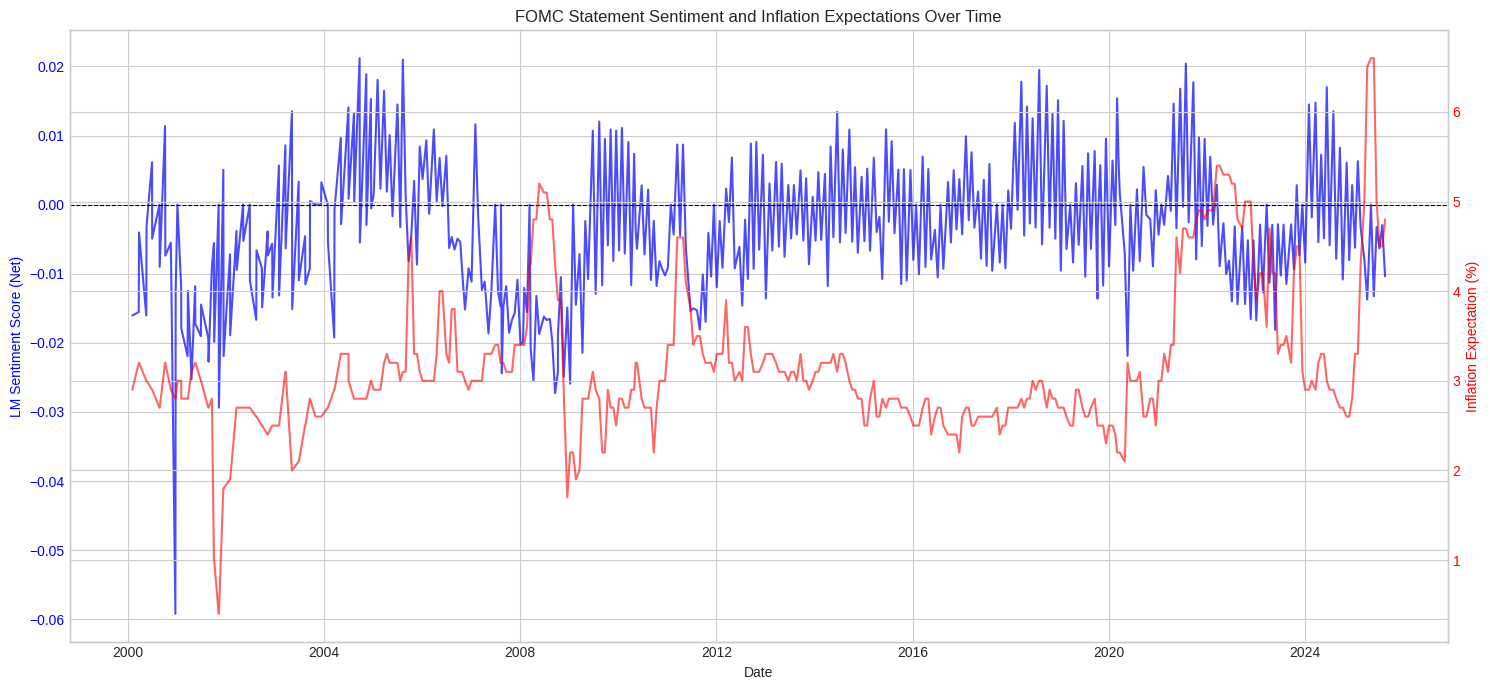

In [7]:
# Part 4 - A: Baseline Sentiment Analysis

# Load Merged Data
print("--- Step 4.1: Loading the merged data from Part 3 ---")
final_csv_path = os.path.join(DATA_PATH, 'final_merged_data.csv')
df = pd.read_csv(final_csv_path, parse_dates=['date'])
print("Data loaded successfully.")

# Download and Process the LM Master Dictionary
print("\n--- Step 4.2: Downloading and Processing LM Master Dictionary ---")
import gdown
gdrive_file_id = '1cfg_w3USlRFS97wo7XQmYnuzhpmzboAY'
csv_output_path = '/content/LoughranMcDonald_MasterDictionary.csv'
gdown.download(id=gdrive_file_id, output=csv_output_path, quiet=True)
df_dict = pd.read_csv(csv_output_path)

# This logic correctly handles the structure where a year (>0) indicates a word's category
positive_words = set(df_dict[df_dict['Positive'] == 2009]['Word'].str.lower())
negative_words = set(df_dict[df_dict['Negative'] == 2009]['Word'].str.lower())
print(f"Loaded {len(positive_words)} positive and {len(negative_words)} negative words.")

# Sanity Check
print("\n--- Step 4.3: Sanity Check: Manually testing the word lists... ---")
# This test verifies that our word lists are correct and usable.
test_sentence = "the economy shows abundant signs of durable and strong growth with acceptable risk."
test_tokens = re.findall(r'[a-zA-Z]+', test_sentence.lower())
found_pos = [word for word in test_tokens if word in positive_words]
found_neg = [word for word in test_tokens if word in negative_words]

print(f"Test sentence: '{test_sentence}'")
print(f"Found positive words in test sentence: {found_pos}")
print(f"Found negative words in test sentence: {found_neg}")


# Define the Sentiment Scoring Function
print("\n--- Step 4.4: Defining the sentiment scoring function ---")
def calculate_lm_sentiment(text):
    tokens = re.findall(r'[a-zA-Z]+', str(text).lower())
    pos_count = sum(1 for word in tokens if word in positive_words)
    neg_count = sum(1 for word in tokens if word in negative_words)
    total_words = len(tokens)
    if total_words == 0: return 0.0
    sentiment_score = (pos_count - neg_count) / total_words
    return sentiment_score

# Apply the Function to the DataFrame
print("\n--- Step 4.5: Applying the function to all statements... ---")
df['lm_sentiment'] = df['statement_text'].apply(calculate_lm_sentiment)
print("Sentiment calculation complete.")

# Verify, Analyze, and Visualize
print("Step 4.6: Verifying and Analyzing the Results")

if (df['lm_sentiment'] == 0).all():
    print("CRITICAL ERROR: All sentiment scores are still zero. This indicates a persistent, unexpected issue.")
else:
    print("SUCCESS: Non-zero sentiment scores were calculated.")

print("Sample of DataFrame with new 'lm_sentiment' column:")
print(df[['date', 'lm_sentiment']].head().to_string())
print("Most Hawkish (Negative Sentiment) Statements:")
print(df.nsmallest(5, 'lm_sentiment')[['date', 'lm_sentiment']].to_string())
print("Most Dovish (Positive Sentiment) Statements:")
print(df.nlargest(5, 'lm_sentiment')[['date', 'lm_sentiment']].to_string())

print("Visualizing sentiment over time")
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax1 = plt.subplots(figsize=(15, 7))
ax1.plot(df['date'], df['lm_sentiment'], color='blue', label='LM Sentiment Score', alpha=0.7)
ax1.set_xlabel('Date')
ax1.set_ylabel('LM Sentiment Score (Net)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('FOMC Statement Sentiment and Inflation Expectations Over Time')
ax1.axhline(0, color='black', linestyle='--', linewidth=0.8)
ax2 = ax1.twinx()
ax2.plot(df['date'], df['inflation_expectation'], color='red', label='Inflation Expectation (%)', alpha=0.6)
ax2.set_ylabel('Inflation Expectation (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
fig.tight_layout()
plt.show()

Engineering a new 'Uncertainty' feature
Created a list of 297 uncertainty-related words.
Applying the uncertainty scoring function to all statements...
Uncertainty score calculation complete.
Analyzing and visualizing the new Uncertainty Score
Sample of DataFrame with the new 'uncertainty_score' column:
        date  uncertainty_score
0 2025-08-20           0.018360
1 2025-07-30           0.020833
2 2025-07-09           0.022993
3 2025-06-18           0.022801
4 2025-05-28           0.022161
Top 5 statements with the HIGHEST uncertainty:
          date  uncertainty_score
307 2007-01-31           0.052326
417 2000-06-28           0.049080
404 2001-03-20           0.048246
352 2004-05-04           0.043478
370 2003-03-18           0.042918


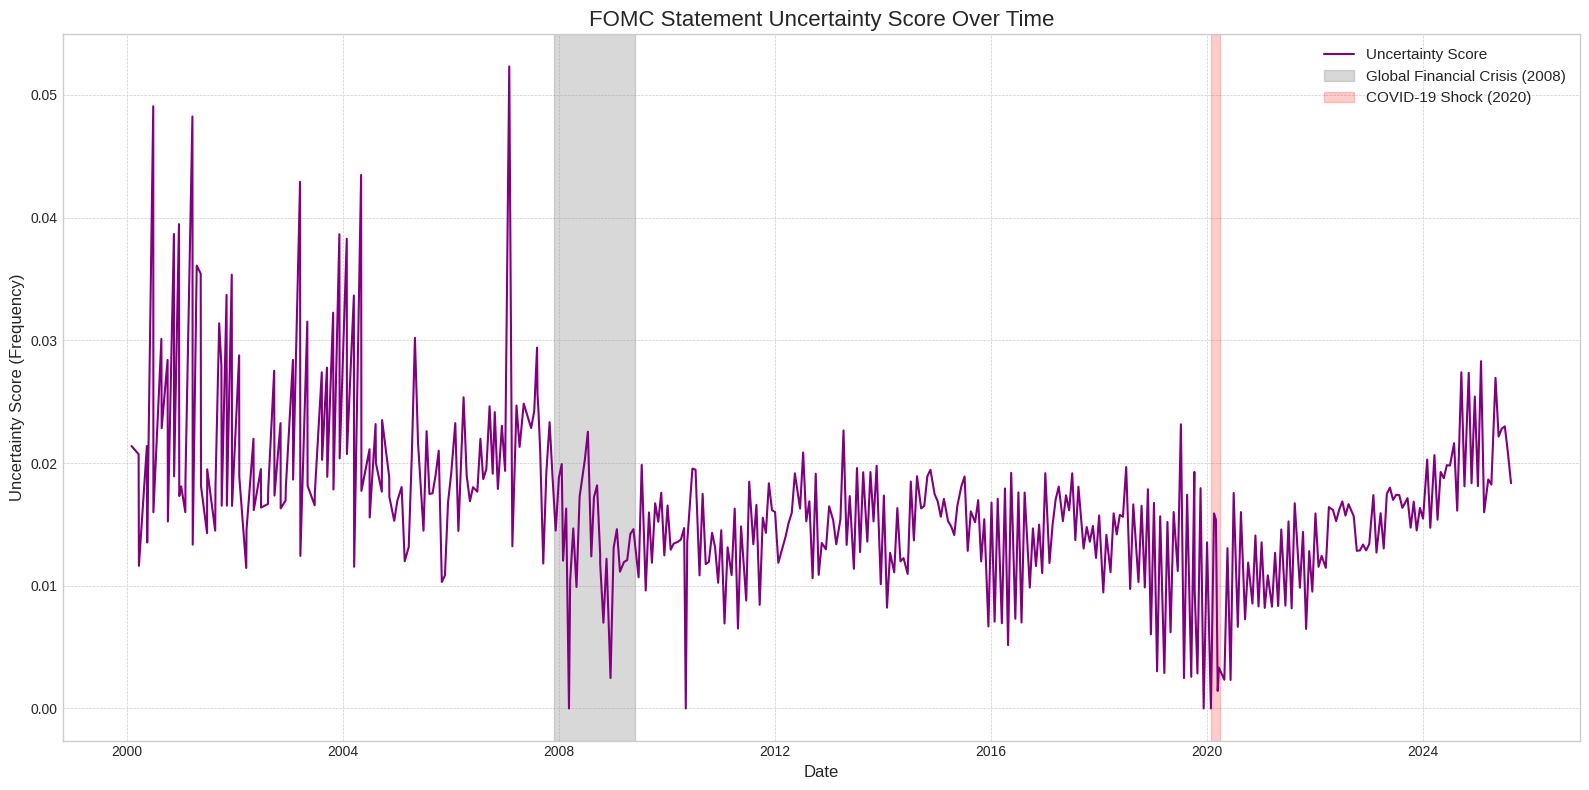

In [8]:
# Part 4 - B

print("Engineering a new 'Uncertainty' feature")

# --- Step 1: Ensure the main DataFrame and the Dictionary are loaded ---
# The 'df' DataFrame should already be in memory from Part 4a.
# We will reload the dictionary to be safe.
dict_csv_path = '/content/LoughranMcDonald_MasterDictionary.csv'
df_dict = pd.read_csv(dict_csv_path)

# --- Step 2: Create the 'Uncertainty' Word List ---
# We filter the dictionary for words where the 'Uncertainty' column is greater than 0
uncertainty_words = set(df_dict[df_dict['Uncertainty'] > 0]['Word'].str.lower())
print(f"Created a list of {len(uncertainty_words)} uncertainty-related words.")

# --- Step 3: Define the Uncertainty Scoring Function ---
def calculate_uncertainty_score(text):
    """
    Calculates the uncertainty of a text by counting the frequency of uncertainty words.
    """
    tokens = re.findall(r'[a-zA-Z]+', str(text).lower())

    # Count uncertainty words
    uncertain_count = sum(1 for word in tokens if word in uncertainty_words)

    total_words = len(tokens)
    if total_words == 0:
        return 0.0

    # The score is the ratio of uncertainty words to total words
    uncertainty_score = uncertain_count / total_words
    return uncertainty_score

# --- Step 4: Apply the Function to the DataFrame ---
print("Applying the uncertainty scoring function to all statements...")
df['uncertainty_score'] = df['statement_text'].apply(calculate_uncertainty_score)
print("Uncertainty score calculation complete.")


# --- Step 5: Analyze and Visualize the New Feature ---
print("Analyzing and visualizing the new Uncertainty Score")

print("Sample of DataFrame with the new 'uncertainty_score' column:")
print(df[['date', 'uncertainty_score']].head().to_string())

print("Top 5 statements with the HIGHEST uncertainty:")
print(df.nlargest(5, 'uncertainty_score')[['date', 'uncertainty_score']].to_string())


# --- Visualization ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(df['date'], df['uncertainty_score'], label='Uncertainty Score', color='purple')

# Highlight major economic events for context
ax.axvspan('2007-12-01', '2009-06-01', color='gray', alpha=0.3, label='Global Financial Crisis (2008)')
ax.axvspan('2020-02-01', '2020-04-01', color='red', alpha=0.2, label='COVID-19 Shock (2020)')


# Formatting
ax.set_title('FOMC Statement Uncertainty Score Over Time', fontsize=16)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Uncertainty Score (Frequency)', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

In [15]:
# Part 4 - C

# Load the Pre-trained FinBERT Model
print("--- Loading the pre-trained FinBERT model and tokenizer ---")
model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
if torch.cuda.is_available():
    model.to('cuda')
    print("Model moved to GPU.")

# Define the FinBERT Sentiment Scoring Function
def get_finbert_sentiment(text):
    if pd.isna(text) or text.strip() == "": return 0.0
    try:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512, padding=True)
        if torch.cuda.is_available():
            inputs = {k: v.to('cuda') for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
        scores = torch.nn.functional.softmax(outputs.logits, dim=-1)[0]
        prob_positive = scores[0].item()
        prob_negative = scores[1].item()
        sentiment_score = prob_positive - prob_negative
        return sentiment_score
    except Exception as e: return np.nan

# Apply the FinBERT Function to the DataFrame
print("Applying FinBERT to all historical statements (this will be slow)...")
df['finbert_sentiment'] = df['statement_text'].apply(get_finbert_sentiment)
df['finbert_sentiment'].fillna(0, inplace=True)
print("\nFinBERT sentiment calculation for the full dataset is complete.")

# Display final DataFrame with all features
print("\nSample of DataFrame with all engineered features:")
print(df[['date', 'lm_sentiment', 'uncertainty_score', 'finbert_sentiment']].head().to_string())

--- Loading the pre-trained FinBERT model and tokenizer ---
Model moved to GPU.
Applying FinBERT to all historical statements (this will be slow)...

FinBERT sentiment calculation for the full dataset is complete.

Sample of DataFrame with all engineered features:
        date  lm_sentiment  uncertainty_score  finbert_sentiment
0 2025-08-20     -0.010371           0.018360           0.146874
1 2025-07-30     -0.002976           0.020833          -0.116935
2 2025-07-09     -0.006348           0.022993           0.135644
3 2025-06-18     -0.003257           0.022801           0.013849
4 2025-05-28     -0.013244           0.022161           0.453079


/tmp/ipython-input-1501875256.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['finbert_sentiment'].fillna(0, inplace=True)


Part 5: Time Series Modeling

In [10]:
# Part 5 - A

print("Part 5a: Preparing all features for modeling")

# Load Data and Set Index
df_model = df.copy()

# Set and sort the date index to ensure correct chronological order
df_model.set_index('date', inplace=True)
df_model.sort_index(inplace=True)
print(f"Data loaded. Full range: {df_model.index.min().date()} to {df_model.index.max().date()}")

# Create Lagged Features
print("Step 5.2: Creating lagged features for the target variable")
for i in range(1, 4):
    df_model[f'inflation_lag_{i}'] = df_model['inflation_expectation'].shift(i)
df_model.dropna(inplace=True)
print(f"Lagged features created. Remaining data points: {len(df_model)}")

# Define Features (X) and Target (y)
print("Step 5.3: Defining feature set (X) and target (y)")
y = df_model['inflation_expectation']
X = df_model.drop(columns=['inflation_expectation', 'statement_text'])
print("Feature set (X) columns:", X.columns.tolist())

# Chronological Train-Test Split (80/20)
print("Performing chronological train-test split")
split_ratio = 0.8
split_index = int(len(X) * split_ratio)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]
print(f"Training set size: {len(X_train)} observations ({X_train.index.min().date()} to {X_train.index.max().date()})")
print(f"Testing set size:  {len(X_test)} observations ({X_test.index.min().date()} to {X_test.index.max().date()})")

# --- Step 5.5: Scale the Features ---
print("Step 5.5: Scaling the features")
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
print("Features have been scaled correctly without data leakage.")
print("Sample of scaled training data:")
print(X_train_scaled.head())

print("Data preparation for modeling is complete!")
print("Variables created: X_train, y_train, X_test, y_test, X_train_scaled, X_test_scaled")

Part 5a: Preparing all features for modeling
Data loaded. Full range: 2000-02-02 to 2025-08-20
Step 5.2: Creating lagged features for the target variable
Lagged features created. Remaining data points: 420
Step 5.3: Defining feature set (X) and target (y)
Feature set (X) columns: ['lm_sentiment', 'uncertainty_score', 'finbert_sentiment', 'inflation_lag_1', 'inflation_lag_2', 'inflation_lag_3']
Performing chronological train-test split
Training set size: 336 observations (2000-05-16 to 2020-05-20)
Testing set size:  84 observations (2020-06-10 to 2025-08-20)
Step 5.5: Scaling the features
Features have been scaled correctly without data leakage.
Sample of scaled training data:
            lm_sentiment  uncertainty_score  finbert_sentiment  \
date                                                             
2000-05-16     -1.154106           0.609372          -0.572623   
2000-05-18      0.080970          -0.457075          -0.156613   
2000-06-28      0.971655           4.366957        

Defining Feature Sets for Each Model

--- Training Model: 1. Baseline (Lags Only) ---
Test RMSE: 0.4709
Test MAE:  0.3295

--- Training Model: 2. Lags + LM Sentiment ---
Test RMSE: 0.4706
Test MAE:  0.3295

--- Training Model: 3. Lags + FinBERT Sentiment ---
Test RMSE: 0.4739
Test MAE:  0.3323

--- Step 5.7: Comparing Model Performance ---
                                 RMSE       MAE
1. Baseline (Lags Only)      0.470872  0.329529
2. Lags + LM Sentiment       0.470644  0.329517
3. Lags + FinBERT Sentiment  0.473869  0.332277

--- Step 5.8: Visualizing Predictions vs. Actual Values ---


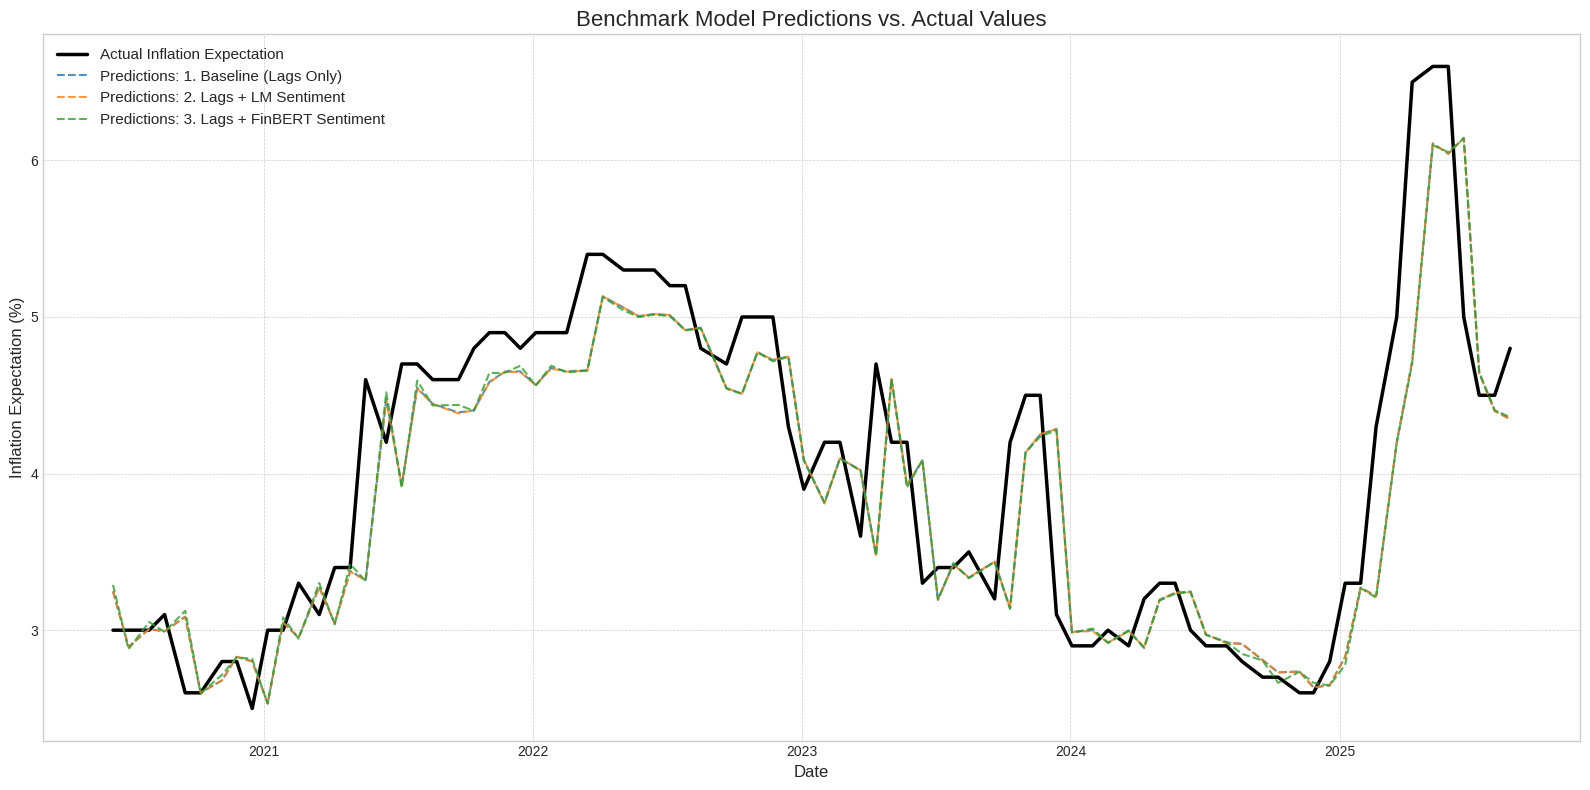

In [11]:
# Part 5 - B


print("Defining Feature Sets for Each Model")

# Model 1: Baseline features (only past inflation values)
features_baseline = [col for col in X_train_scaled.columns if 'lag' in col]

# Model 2: Baseline features + LM Sentiment
features_lm = features_baseline + ['lm_sentiment']

# Model 3: Baseline features + FinBERT Sentiment
features_finbert = features_baseline + ['finbert_sentiment']

# Dictionary to store results for easy comparison
results = {}

# --- Helper function for training and evaluating ---
def train_and_evaluate(model_name, features, X_train, y_train, X_test, y_test):
    print(f"\n--- Training Model: {model_name} ---")

    # Initialize and train the model
    model = LinearRegression()
    model.fit(X_train[features], y_train)

    # Make predictions on the test set
    predictions = model.predict(X_test[features])

    # Calculate error metrics
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)

    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test MAE:  {mae:.4f}")

    # Store results
    results[model_name] = {'RMSE': rmse, 'MAE': mae, 'Predictions': predictions}

# --- Train all three models ---
train_and_evaluate('1. Baseline (Lags Only)', features_baseline, X_train_scaled, y_train, X_test_scaled, y_test)
train_and_evaluate('2. Lags + LM Sentiment', features_lm, X_train_scaled, y_train, X_test_scaled, y_test)
train_and_evaluate('3. Lags + FinBERT Sentiment', features_finbert, X_train_scaled, y_train, X_test_scaled, y_test)

# Compare Model Performance
print("\n--- Step 5.7: Comparing Model Performance ---")
results_df = pd.DataFrame(results).T.drop(columns=['Predictions'])
print(results_df)

# Visualize Predictions vs. Actuals
print("\n--- Step 5.8: Visualizing Predictions vs. Actual Values ---")
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(16, 8))

# Plot the actual values from the test set
ax.plot(y_test.index, y_test, label='Actual Inflation Expectation', color='black', linewidth=2.5)

# Plot predictions from each model
for model_name, data in results.items():
    ax.plot(y_test.index, data['Predictions'], label=f'Predictions: {model_name}', linestyle='--', alpha=0.8)

# Formatting
ax.set_title('Benchmark Model Predictions vs. Actual Values', fontsize=16)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Inflation Expectation (%)', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

Shape of training features for LSTM: (333, 3, 4)
Shape of testing features for LSTM: (81, 3, 4)

--- Step 5.10: Building and compiling the LSTM model ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,051 (43.17 KB)

 Trainable params: 11,051 (43.17 KB)

 Non-trainable params: 0 (0.00 B)


--- Step 5.11: Training the LSTM model (this will take a few moments)... ---
Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 8.2678 - val_loss: 4.7783
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.5865 - val_loss: 2.2508
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.0500 - val_loss: 0.8721
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4424 - val_loss: 0.2639
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8012 - val_loss: 0.1723
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5590 - val_loss: 0.1378
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5231 - val_loss: 0.0996
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4143 - val_loss: 0.0801
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3456 - val_loss: 0.0608
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4266 - val_loss: 0.0616
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3185 - val_loss: 0.

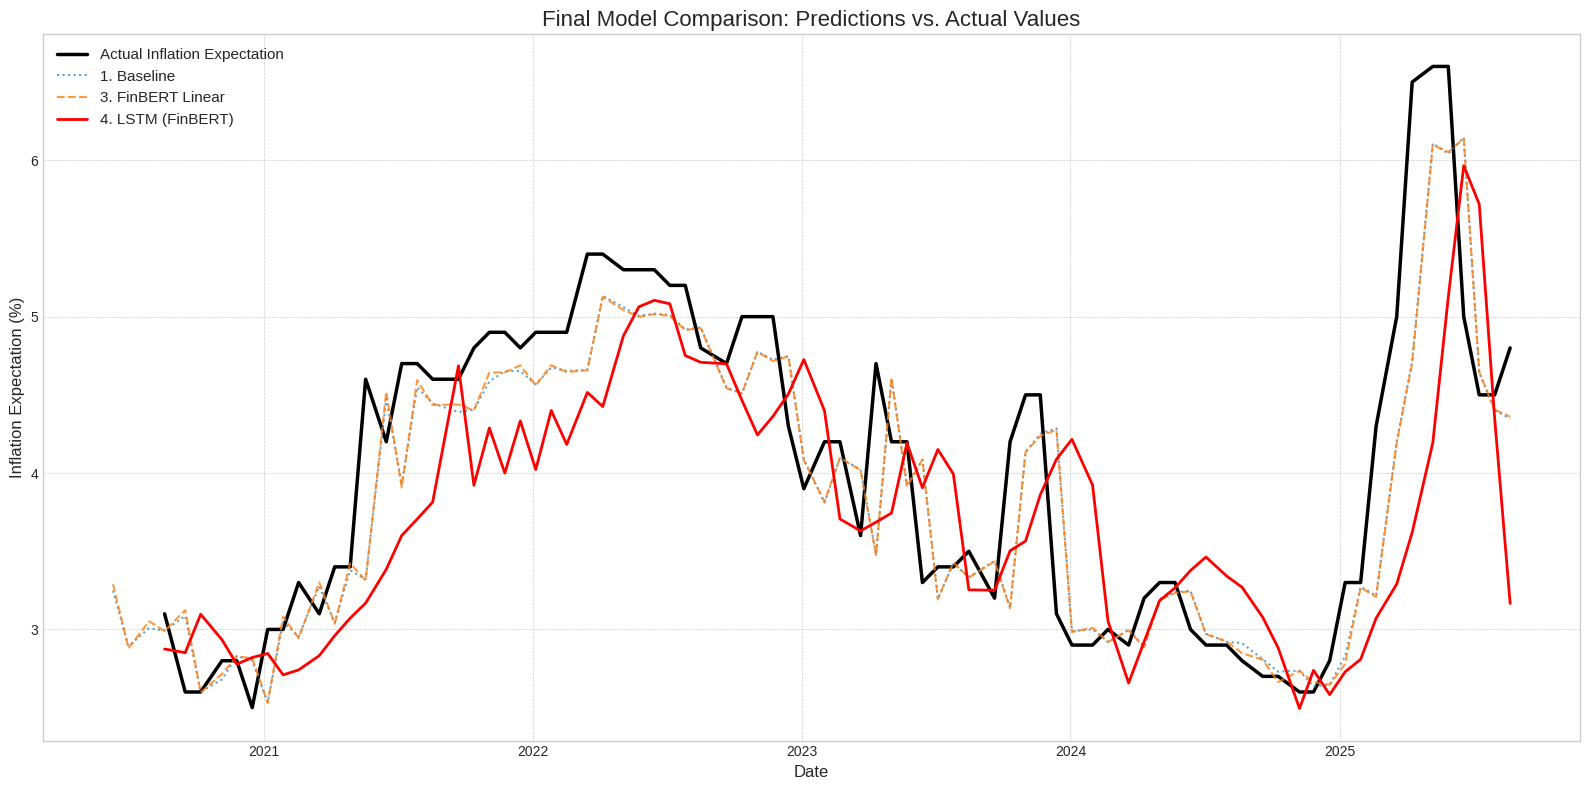

In [12]:
# Part 5 - C


# Reshape Data for LSTM
# LSTMs expect data in a 3D format: [samples, timesteps, features]
# - samples: number of data points
# - timesteps: how many past steps to look at for each prediction
# - features: number of features at each step

def to_sequences(X, y, timesteps=1):
    X_seq, y_seq = [], []
    for i in range(len(X) - timesteps):
        X_seq.append(X.iloc[i:(i + timesteps)].values)
        y_seq.append(y.iloc[i + timesteps])
    return np.array(X_seq), np.array(y_seq)

# We will use 3 timesteps, meaning the model looks at the past 3 data points to predict the next one.
TIMESTEPS = 3

# We will use the best feature set from our benchmark models: Lags + FinBERT Sentiment
features_finbert = [col for col in X_train_scaled.columns if 'lag' in col or 'finbert' in col]

X_train_lstm_in, y_train_lstm_in = to_sequences(X_train_scaled[features_finbert], y_train, TIMESTEPS)
X_test_lstm_in, y_test_lstm_in = to_sequences(X_test_scaled[features_finbert], y_test, TIMESTEPS)

print(f"Shape of training features for LSTM: {X_train_lstm_in.shape}")
print(f"Shape of testing features for LSTM: {X_test_lstm_in.shape}")


# Build and Compile the LSTM Model
print("\n--- Step 5.10: Building and compiling the LSTM model ---")

# Get the shape for the input layer
n_features = X_train_lstm_in.shape[2]

model_lstm = Sequential()
model_lstm.add(LSTM(units=50, activation='relu', input_shape=(TIMESTEPS, n_features)))
model_lstm.add(Dropout(0.2)) # Dropout layer to prevent overfitting
model_lstm.add(Dense(units=1))

# Compile the model
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.summary()


# Train the LSTM Model
print("\n--- Step 5.11: Training the LSTM model (this will take a few moments)... ---")
# We train the model. `epochs` is the number of times we go through the training data.
history = model_lstm.fit(X_train_lstm_in, y_train_lstm_in,
                         epochs=50,
                         batch_size=8,
                         validation_split=0.1, # Use 10% of training data for validation
                         verbose=1)


# Evaluate the LSTM Model
print("\n--- Step 5.12: Evaluating the LSTM model ---")
lstm_predictions = model_lstm.predict(X_test_lstm_in)

# Calculate error metrics
# Note: y_test_lstm_in are the actual values corresponding to the LSTM predictions
rmse_lstm = np.sqrt(mean_squared_error(y_test_lstm_in, lstm_predictions))
mae_lstm = mean_absolute_error(y_test_lstm_in, lstm_predictions)

print(f"LSTM Test RMSE: {rmse_lstm:.4f}")
print(f"LSTM Test MAE:  {mae_lstm:.4f}")

# Add LSTM results to our results dictionary for the final comparison
results['4. LSTM (Lags + FinBERT)'] = {'RMSE': rmse_lstm, 'MAE': mae_lstm, 'Predictions': lstm_predictions.flatten()}

# Final Comparison
print("\n--- Step 5.13: Final Model Performance Comparison ---")
final_results_df = pd.DataFrame(results).T.drop(columns=['Predictions'])
print(final_results_df.sort_values(by='RMSE'))


# Final Visualization
print("\n--- Step 5.14: Final Visualization with All Models ---")
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(16, 8))

# Plot actuals. Note that the test set for LSTM is shorter by TIMESTEPS.
ax.plot(y_test.index[TIMESTEPS:], y_test_lstm_in, label='Actual Inflation Expectation', color='black', linewidth=2.5)

# Plot benchmark predictions
ax.plot(y_test.index, results['1. Baseline (Lags Only)']['Predictions'], label='1. Baseline', linestyle=':', alpha=0.7)
ax.plot(y_test.index, results['3. Lags + FinBERT Sentiment']['Predictions'], label='3. FinBERT Linear', linestyle='--', alpha=0.8)

# Plot LSTM predictions
ax.plot(y_test.index[TIMESTEPS:], lstm_predictions, label='4. LSTM (FinBERT)', color='red', linestyle='-', linewidth=2)

# Formatting
ax.set_title('Final Model Comparison: Predictions vs. Actual Values', fontsize=16)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Inflation Expectation (%)', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

XGBoost Model Implementation

Data re-prepared successfully with correct time index.

--- Training XGBoost Model: 5. XGBoost (FinBERT) ---
Test RMSE: 0.5218
Test MAE:  0.3687

--- Training XGBoost Model: 6. XGBoost (FinBERT + Uncertainty) ---
Test RMSE: 0.5223
Test MAE:  0.3711

--- Final Model Performance Comparison (including XGBoost) ---
                                        RMSE       MAE
2. Lags + LM Sentiment              0.470644  0.329517
1. Baseline (Lags Only)             0.470872  0.329529
3. Lags + FinBERT Sentiment         0.473869  0.332277
5. XGBoost (FinBERT)                0.521787  0.368694
6. XGBoost (FinBERT + Uncertainty)  0.522336  0.371139

--- Final Visualization with Best Models ---


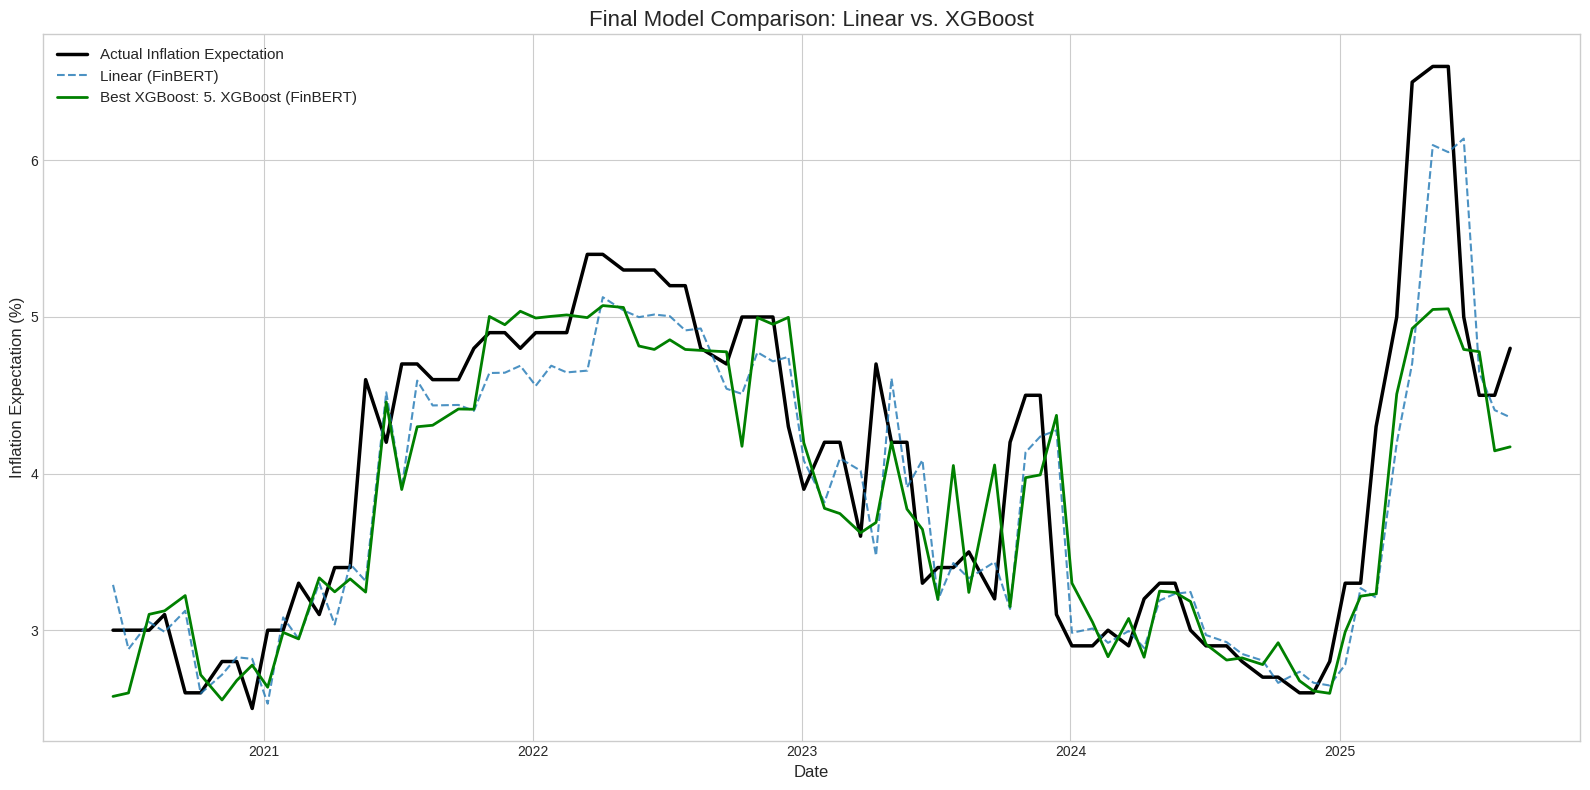

In [13]:
# Part 5 - D: Implementing the Advanced XGBoost Model

# Install XGBoost library
!pip install -q xgboost


print("XGBoost Model Implementation")

# Re-prepare data and set correct index
df_model_xgb = df.copy()
df_model_xgb.set_index('date', inplace=True)
df_model_xgb.sort_index(inplace=True)

# Create lagged features
for i in range(1, 4):
    df_model_xgb[f'inflation_lag_{i}'] = df_model_xgb['inflation_expectation'].shift(i)

df_model_xgb.dropna(inplace=True)

# Define full feature set (X) and target (y)
y_xgb = df_model_xgb['inflation_expectation']
X_xgb = df_model_xgb.drop(columns=['inflation_expectation', 'statement_text'])

# Chronological Train-Test Split
split_ratio = 0.8
split_index = int(len(X_xgb) * split_ratio)
X_train_xgb, X_test_xgb = X_xgb[:split_index], X_xgb[split_index:]
y_train_xgb, y_test_xgb = y_xgb[:split_index], y_xgb[split_index:]

# Scale the Features
numeric_cols = X_train_xgb.select_dtypes(include=np.number).columns
scaler_xgb = StandardScaler()
X_train_xgb_scaled = X_train_xgb.copy()
X_test_xgb_scaled = X_test_xgb.copy()
X_train_xgb_scaled[numeric_cols] = scaler_xgb.fit_transform(X_train_xgb[numeric_cols])
X_test_xgb_scaled[numeric_cols] = scaler_xgb.transform(X_test_xgb[numeric_cols])
print("\nData re-prepared successfully with correct time index.")

# Train and Evaluate XGBoost Models
features_finbert = [col for col in X_train_xgb_scaled.columns if 'lag' in col or 'finbert' in col]
features_finbert_uncertainty = features_finbert + ['uncertainty_score']
if 'results' not in locals(): results = {}

def train_evaluate_xgb(model_name, features, X_train, y_train, X_test, y_test):
    print(f"\n--- Training XGBoost Model: {model_name} ---")
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                                 n_estimators=1000,
                                 learning_rate=0.05,
                                 early_stopping_rounds=10)

    xgb_model.fit(X_train[features], y_train,
                  eval_set=[(X_test[features], y_test)],
                  verbose=False)

    predictions = xgb_model.predict(X_test[features])

    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)

    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test MAE:  {mae:.4f}")
    results[model_name] = {'RMSE': rmse, 'MAE': mae, 'Predictions': predictions}

train_evaluate_xgb('5. XGBoost (FinBERT)', features_finbert, X_train_xgb_scaled, y_train_xgb, X_test_xgb_scaled, y_test_xgb)
train_evaluate_xgb('6. XGBoost (FinBERT + Uncertainty)', features_finbert_uncertainty, X_train_xgb_scaled, y_train_xgb, X_test_xgb_scaled, y_test_xgb)

# Final Comparison of ALL Models
print("\n--- Final Model Performance Comparison (including XGBoost) ---")
results_to_compare = {k: v for k, v in results.items() if 'LSTM' not in k}
final_results_df = pd.DataFrame(results_to_compare).T.drop(columns=['Predictions'])
print(final_results_df.sort_values(by='RMSE'))

# Final Visualization
print("\n--- Final Visualization with Best Models ---")
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(y_test_xgb.index, y_test_xgb, label='Actual Inflation Expectation', color='black', linewidth=2.5)
if '3. Lags + FinBERT Sentiment' in results:
    ax.plot(y_test.index, results['3. Lags + FinBERT Sentiment']['Predictions'], label='Linear (FinBERT)', linestyle='--', alpha=0.8)
best_xgb_model_name = final_results_df.loc[final_results_df.index.str.contains('XGBoost')]['RMSE'].idxmin()
ax.plot(y_test_xgb.index, results[best_xgb_model_name]['Predictions'], label=f'Best XGBoost: {best_xgb_model_name}', color='green', linestyle='-', linewidth=2)
ax.set_title('Final Model Comparison: Linear vs. XGBoost', fontsize=16)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Inflation Expectation (%)', fontsize=12)
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

# Part 6: Final Model Validation (Walk-Forward Method)

*In this final section, we use the gold standard for time series evaluation, Walk-Forward Validation, to get the most reliable performance metric for our champion model (XGBoost). This gives us the definitive result of our project.*

In [14]:
# Part 6


print("Starting Walk-Forward Validation for the Champion Model")

# Prepare the full, final dataset
df_final_val = df.copy()
df_final_val.set_index('date', inplace=True)
df_final_val.sort_index(inplace=True)

# Create lagged features
for i in range(1, 4):
    df_final_val[f'inflation_lag_{i}'] = df_final_val['inflation_expectation'].shift(i)

df_final_val.dropna(inplace=True)

# Define the best feature set and the full X and y
best_features = [col for col in df_final_val.columns if 'lag' in col or 'finbert' in col or 'uncertainty' in col]
y = df_final_val['inflation_expectation']
X = df_final_val[best_features]

print(f"Full dataset prepared for validation. Shape: {X.shape}")


# Set up the TimeSeriesSplit
N_SPLITS = 5
tscv = TimeSeriesSplit(n_splits=N_SPLITS)

# List to store the RMSE score from each fold
rmse_scores = []
fold_counter = 1

print(f"\nStarting {N_SPLITS}-Fold Time Series Cross-Validation...")

# Loop through each split, train, and evaluate
for train_index, test_index in tscv.split(X):
    print(f"\n--- Fold {fold_counter}/{N_SPLITS} ---")

    # Create the training and testing sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    print(f"Train period: {X_train.index.min().date()} to {X_train.index.max().date()} ({len(X_train)} samples)")
    print(f"Test period:  {X_test.index.min().date()} to {X_test.index.max().date()} ({len(X_test)} samples)")

    # IMPORTANT: Scale the data INSIDE the loop to prevent data leakage
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize and train the champion model (XGBoost)
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.05)
    xgb_model.fit(X_train_scaled, y_train, verbose=False)

    # Make predictions and calculate error
    predictions = xgb_model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    rmse_scores.append(rmse)
    print(f"RMSE for this fold: {rmse:.4f}")

    fold_counter += 1

# Report the Final, Robust Performance Score
print("Walk-Forward Validation Complete")
mean_rmse = np.mean(rmse_scores)
std_rmse = np.std(rmse_scores)

print(f"Final Robust RMSE (Mean over {N_SPLITS} folds): {mean_rmse:.4f}")
print(f"   Standard Deviation of RMSE across folds: {std_rmse:.4f}")

Starting Walk-Forward Validation for the Champion Model
Full dataset prepared for validation. Shape: (420, 5)

Starting 5-Fold Time Series Cross-Validation...

--- Fold 1/5 ---
Train period: 2000-05-16 to 2004-06-30 (70 samples)
Test period:  2004-07-01 to 2008-05-21 (70 samples)
RMSE for this fold: 0.5501

--- Fold 2/5 ---
Train period: 2000-05-16 to 2008-05-21 (140 samples)
Test period:  2008-06-25 to 2012-08-22 (70 samples)
RMSE for this fold: 0.5067

--- Fold 3/5 ---
Train period: 2000-05-16 to 2012-08-22 (210 samples)
Test period:  2012-09-13 to 2017-01-04 (70 samples)
RMSE for this fold: 0.1858

--- Fold 4/5 ---
Train period: 2000-05-16 to 2017-01-04 (280 samples)
Test period:  2017-02-01 to 2021-04-07 (70 samples)
RMSE for this fold: 0.2711

--- Fold 5/5 ---
Train period: 2000-05-16 to 2021-04-07 (350 samples)
Test period:  2021-04-28 to 2025-08-20 (70 samples)
RMSE for this fold: 0.5632
Walk-Forward Validation Complete
Final Robust RMSE (Mean over 5 folds): 0.4154
   Standard D